# Chapter 10: Visual SLAM을 위한 카메라 모델과 번들 조정

## 🎯 학습 목표

이 챕터에서는 Visual SLAM의 핵심인 카메라 모델과 번들 조정(Bundle Adjustment)을 배웁니다.

- 카메라 캘리브레이션과 투영 모델
- 3D 점을 이미지로 투영/역투영
- Visual feature의 에러 함수
- 번들 조정 최적화
- SymForce의 카메라 모델 활용

## ⚠️ 중요 사항

이 노트북을 실행하기 전에:
- 다른 SymForce 노트북이 실행 중이라면 커널을 재시작하세요
- `AlreadyUsedEpsilon` 오류가 발생하면 cell 2의 `set_epsilon_to_number` 라인을 주석 처리하세요

## 📚 이론적 배경

### 핀홀 카메라 모델

3D 점 $P = [X, Y, Z]^T$를 이미지 좌표 $p = [u, v]^T$로 투영:

$$p = K \cdot \pi(P)$$

여기서:
- $K$: 내부 파라미터 행렬 (focal length, principal point)
- $\pi$: 투영 함수 $[X/Z, Y/Z]^T$

### 번들 조정 (Bundle Adjustment)

카메라 포즈와 3D 점을 동시에 최적화:

$$\min_{\{T_i\}, \{P_j\}} \sum_{i,j} \rho(||p_{ij} - \pi(T_i, P_j)||^2_{\Sigma_{ij}})$$

## 🔧 필요한 라이브러리 임포트

In [162]:
import numpy as np
import symforce
# symforce.set_epsilon_to_number(1e-8)  # 이미 설정된 경우 주석 처리

import symforce.symbolic as sf
from symforce import codegen
from symforce.opt.optimizer import Optimizer
from symforce.opt.factor import Factor
from symforce.values import Values

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 현재 epsilon 값 확인
print(f"✅ 라이브러리 준비 완료!")
print(f"   현재 epsilon: {sf.numeric_epsilon}")

✅ 라이브러리 준비 완료!
   현재 epsilon: 2.220446049250313e-15


## 1. SymForce 카메라 모델

SymForce는 다양한 카메라 모델을 제공합니다.

In [163]:
# 선형 카메라 캘리브레이션 (핀홀 모델)
linear_cal = sf.LinearCameraCal(
    focal_length=[500.0, 500.0],  # fx, fy
    principal_point=[320.0, 240.0]  # cx, cy
)

print("📷 선형 카메라 캘리브레이션:")
print(f"   초점 거리: {linear_cal.focal_length}")
print(f"   주점: {linear_cal.principal_point}")

# 이미지 크기를 포함한 카메라 객체
camera = sf.Camera(
    calibration=linear_cal,
    image_size=(640, 480)
)

print(f"\n   이미지 크기: {camera.image_size}")

📷 선형 카메라 캘리브레이션:
   초점 거리: [500.0]
[500.0]

   주점: [320.0]
[240.0]


   이미지 크기: [640]
[480]



### 1.1 투영과 역투영

In [164]:
# 3D 점을 이미지로 투영
point_3d = sf.V3(1.0, 0.5, 2.0)  # 카메라 좌표계의 점
pixel, is_valid = camera.pixel_from_camera_point(point_3d)

print("🎯 투영 (3D → 2D):")
print(f"   3D 점: {point_3d.to_storage()}")
print(f"   픽셀: {pixel.to_storage()}")
print(f"   유효: {is_valid}")

# 픽셀을 3D ray로 역투영
pixel_coord = sf.V2(400.0, 300.0)
ray, is_valid = camera.camera_ray_from_pixel(pixel_coord)

print("\n🎯 역투영 (2D → 3D ray):")
print(f"   픽셀: {pixel_coord.to_storage()}")
print(f"   Ray: {ray.to_storage()}")
print(f"   Ray 노름: {ray.norm()}")

🎯 투영 (3D → 2D):
   3D 점: [1.0, 0.5, 2.0]
   픽셀: [570.0, 365.0]
   유효: 1

🎯 역투영 (2D → 3D ray):
   픽셀: [400.0, 300.0]
   Ray: [0.16, 0.12, 1]
   Ray 노름: 1.01980390271856


## 2. Epsilon 처리를 포함한 안전한 투영 함수

In [165]:
def safe_project_point(
    point_3d: sf.V3,
    focal_length: sf.V2,
    principal_point: sf.V2,
    epsilon: sf.Scalar
) -> sf.V2:
    """안전한 카메라 투영 (z=0 특이점 처리)
    
    Args:
        point_3d: 카메라 좌표계의 3D 점
        focal_length: [fx, fy]
        principal_point: [cx, cy]
        epsilon: 특이점 회피를 위한 작은 값
        
    Returns:
        pixel: 이미지 좌표 [u, v]
    """
    # z가 0에 가까울 때 처리
    z_safe = point_3d[2] + epsilon
    
    # 핀홀 카메라 모델
    u = focal_length[0] * point_3d[0] / z_safe + principal_point[0]
    v = focal_length[1] * point_3d[1] / z_safe + principal_point[1]
    
    return sf.V2(u, v)

# 테스트: z가 거의 0인 점
point_near_plane = sf.V3(1.0, 0.5, 0.0001)
pixel_unsafe = sf.V2(
    500.0 * 1.0 / 0.0001 + 320.0,
    500.0 * 0.5 / 0.0001 + 240.0
)

print("⚠️  Epsilon 없이 (z ≈ 0):")
print(f"   픽셀 u ≈ {500.0 * 1.0 / 0.0001:.0f} (이미지 밖!)")

# Symbolic 함수로 테스트
point_sym = sf.V3.symbolic("p")
focal_sym = sf.V2.symbolic("f")
principal_sym = sf.V2.symbolic("c")
eps_sym = sf.Symbol("epsilon")

pixel_safe = safe_project_point(point_sym, focal_sym, principal_sym, eps_sym)
print("\n✅ Epsilon 처리 후 - 안정적인 투영")

⚠️  Epsilon 없이 (z ≈ 0):
   픽셀 u ≈ 5000000 (이미지 밖!)

✅ Epsilon 처리 후 - 안정적인 투영


## 3. PosedCamera: 월드 좌표계 변환

In [166]:
# 카메라 포즈 설정
camera_pose = sf.Pose3(
    R=sf.Rot3.from_yaw_pitch_roll(0.1, -0.2, 0.0),  # 약간 회전
    t=sf.V3(1.0, 0.5, 1.5)  # 월드 좌표계에서의 위치
)

# PosedCamera 생성
posed_camera = sf.PosedCamera(
    pose=camera_pose,
    calibration=linear_cal,
    image_size=(640, 480)
)

# 월드 좌표계의 점을 이미지로 투영
world_point = sf.V3(2.0, 1.0, 3.0)  # 월드 좌표계 (카메라 앞에 있도록 z 조정)
pixel, is_valid = posed_camera.pixel_from_global_point(world_point)

print("🌍 월드 → 이미지 투영:")
print(f"   월드 점: {world_point.to_storage()}")
print(f"   카메라 포즈: t={camera_pose.t.to_storage()}")

# 카메라 좌표계로 변환하여 확인
cam_point = camera_pose.inverse() * world_point
print(f"   카메라 좌표계 점: {[float(p) for p in cam_point.to_storage()]}")

if is_valid and float(cam_point[2]) > 0.1:  # 카메라 앞에 있는지 확인
    pixel_values = [float(p) for p in pixel.to_storage()]
    print(f"   픽셀: {pixel_values}")
else:
    print(f"   픽셀: Invalid (점이 카메라 뒤에 있음)")

# 역투영 (거리 정보 필요)
if is_valid and float(cam_point[2]) > 0.1:
    range_to_point = (world_point - camera_pose.t).norm()
    world_point_recovered, is_valid_back = posed_camera.global_point_from_pixel(
        pixel, range_to_point=range_to_point
    )
    
    print(f"\n🎯 이미지 → 월드 역투영:")
    print(f"   픽셀: {pixel_values}")
    print(f"   거리: {float(range_to_point):.3f}")
    if is_valid_back:
        print(f"   복원된 월드 점: {[float(p) for p in world_point_recovered.to_storage()]}")
    else:
        print(f"   복원 실패")
else:
    print("\n역투영 스킵 (유효하지 않은 투영)")

🌍 월드 → 이미지 투영:
   월드 점: [2.0, 1.0, 3.0]
   카메라 포즈: t=[1.0, 0.5, 1.5]
   카메라 좌표계 점: [1.3220960208980355, 0.39766866599218476, 1.2625061360696737]
   픽셀: [843.5998396862734, 397.4917755370967]

🎯 이미지 → 월드 역투영:
   픽셀: [843.5998396862734, 397.4917755370967]
   거리: 1.871
   복원된 월드 점: [1.9999999999999996, 0.9999999999999999, 3.0]


## 4. Visual Feature 에러 함수

In [167]:
def visual_feature_residual(
    camera_pose: sf.Pose3,
    landmark: sf.V3,
    pixel_measured: sf.V2,
    calibration: sf.LinearCameraCal,
    epsilon: sf.Scalar
) -> sf.V2:
    """Visual feature의 reprojection error
    
    중요: 포즈 정의
    - camera_pose.t는 월드 좌표계에서의 카메라 위치
    - camera_pose.R는 카메라에서 월드로의 회전 (camera-to-world)
    - 따라서 월드 좌표를 카메라 좌표로 변환하려면 pose를 그대로 사용
    
    Args:
        camera_pose: 카메라 포즈 (camera to world transform)
        landmark: 3D 랜드마크 위치 (월드 좌표계)
        pixel_measured: 측정된 픽셀 좌표
        calibration: 카메라 캘리브레이션
        epsilon: 수치 안정성을 위한 값
        
    Returns:
        residual: 2D 픽셀 에러 (predicted - measured)
    """
    # 랜드마크를 카메라 좌표계로 변환
    # camera_pose가 camera-to-world 변환이므로, 
    # world-to-camera는 inverse를 사용
    T_world_to_cam = camera_pose.inverse()
    landmark_cam = T_world_to_cam * landmark
    
    # 카메라 좌표계에서 픽셀로 투영
    pixel_predicted = safe_project_point(
        landmark_cam,
        calibration.focal_length,
        calibration.principal_point,
        epsilon
    )
    
    # Reprojection error
    return pixel_predicted - pixel_measured

# Symbolic 변수로 Jacobian 계산
print("📐 Visual Feature Jacobian 구조:")

# Symbolic 변수들
T_sym = sf.Pose3.symbolic("T")
L_sym = sf.V3.symbolic("L")
p_meas_sym = sf.V2.symbolic("p_m")
cal_sym = sf.LinearCameraCal.symbolic("cal")
eps_sym = sf.Symbol("eps")

# 에러 함수
error_sym = visual_feature_residual(
    T_sym, L_sym, p_meas_sym, cal_sym, eps_sym
)

# Jacobian
J_pose = error_sym.jacobian(T_sym)
J_landmark = error_sym.jacobian(L_sym)

print(f"   ∂error/∂pose: {J_pose.shape} (2×6)")
print(f"   ∂error/∂landmark: {J_landmark.shape} (2×3)")

print("\n📌 포즈 정의 확인:")
print("   - camera_pose.t: 월드 좌표계에서의 카메라 위치")
print("   - camera_pose.R: 카메라에서 월드로의 회전 (camera-to-world)")
print("   - 변환: landmark_cam = pose.inverse() * landmark_world")

📐 Visual Feature Jacobian 구조:
   ∂error/∂pose: (2, 6) (2×6)
   ∂error/∂landmark: (2, 3) (2×3)

📌 포즈 정의 확인:
   - camera_pose.t: 월드 좌표계에서의 카메라 위치
   - camera_pose.R: 카메라에서 월드로의 회전 (camera-to-world)
   - 변환: landmark_cam = pose.inverse() * landmark_world


## 5. 번들 조정 최적화

In [168]:
def create_bundle_adjustment_problem():
    """간단한 번들 조정 문제 생성"""
    
    # 카메라 캘리브레이션
    calibration = sf.LinearCameraCal(
        focal_length=[500.0, 500.0],
        principal_point=[320.0, 240.0]
    )
    
    # Ground truth 설정
    # 3개 카메라가 원을 따라 배치 (원점을 바라보도록)
    true_poses = []
    for i in range(3):
        angle = 2 * np.pi * i / 3
        # 카메라 위치: 원점에서 3미터 떨어진 곳
        cam_x = 3 * np.cos(angle)
        cam_y = 3 * np.sin(angle)
        cam_z = 1.5
        
        # 카메라 위치
        cam_pos = np.array([cam_x, cam_y, cam_z])
        target = np.array([0, 0, 0])
        
        # 카메라가 원점을 바라보도록 회전 행렬 계산
        # Step 1: -Z축 계산 (카메라가 바라보는 방향)
        # 카메라는 -Z 방향을 바라보므로, -Z축이 원점을 향해야 함
        forward = target - cam_pos  # 카메라에서 원점으로의 방향
        forward = forward / np.linalg.norm(forward)
        
        # Z축은 forward의 반대
        z_axis = -forward
        
        # Step 2: X축 계산 (right vector)
        # World up과 forward의 외적
        world_up = np.array([0, 0, 1])
        right = np.cross(forward, world_up)
        if np.linalg.norm(right) < 0.001:  # 카메라가 수직 위/아래를 볼 때
            right = np.array([1, 0, 0])
        else:
            right = right / np.linalg.norm(right)
        x_axis = right
        
        # Step 3: Y축 계산 (up vector)
        # right와 forward의 외적
        up = np.cross(right, forward)
        y_axis = up
        
        # 회전 행렬 구성 [X Y Z]
        R_matrix = np.column_stack([x_axis, y_axis, z_axis])
        
        # SymForce Rot3로 변환
        pose_R = sf.Rot3.from_rotation_matrix(R_matrix)
        
        true_poses.append(sf.Pose3(
            R=pose_R,
            t=sf.V3(cam_x, cam_y, cam_z)
        ))
    
    # 5개 랜드마크 (원점 주변에 배치)
    true_landmarks = [
        sf.V3(0.0, 0.0, 0.0),
        sf.V3(0.5, 0.0, 0.0),
        sf.V3(0.0, 0.5, 0.0),
        sf.V3(0.0, 0.0, 0.5),
        sf.V3(0.3, 0.3, 0.3)
    ]
    
    # 측정값 생성 (픽셀 좌표)
    measurements = {}
    visibility = {}
    
    print("🔍 카메라 가시성 디버그:")
    
    for i, pose in enumerate(true_poses):
        visible_count = 0
        print(f"\n카메라 {i}:")
        print(f"  위치: {[float(p) for p in pose.t]}")
        
        # PosedCamera 생성
        posed_camera = sf.PosedCamera(
            pose=pose,
            calibration=calibration,
            image_size=(640, 480)
        )
        
        for j, landmark in enumerate(true_landmarks):
            # PosedCamera를 사용하여 투영
            pixel, is_valid = posed_camera.pixel_from_global_point(landmark)
            
            if is_valid:
                px = float(pixel[0])
                py = float(pixel[1])
                
                # 이미지 범위 확인
                if 0 <= px <= 640 and 0 <= py <= 480:
                    # 노이즈 추가
                    measurements[(i, j)] = sf.V2(
                        px + np.random.normal(0, 2),
                        py + np.random.normal(0, 2)
                    )
                    visibility[(i, j)] = True
                    visible_count += 1
                    print(f"    랜드마크 {j}: 보임 (픽셀: [{px:.1f}, {py:.1f}])")
                else:
                    print(f"    랜드마크 {j}: 이미지 밖 (픽셀: [{px:.1f}, {py:.1f}])")
            else:
                print(f"    랜드마크 {j}: 투영 실패")
        
        print(f"  총 {visible_count}개 랜드마크 관측")
    
    # 초기 추정값 (노이즈 포함)
    initial_poses = []
    for pose in true_poses:
        # 작은 회전 노이즈
        noise_R = sf.Rot3.from_yaw_pitch_roll(
            np.random.normal(0, 0.05),
            np.random.normal(0, 0.05),
            np.random.normal(0, 0.05)
        )
        # 위치 노이즈
        noise_t = sf.V3(
            float(pose.t[0]) + np.random.normal(0, 0.1),
            float(pose.t[1]) + np.random.normal(0, 0.1),
            float(pose.t[2]) + np.random.normal(0, 0.1)
        )
        initial_poses.append(sf.Pose3(R=pose.R * noise_R, t=noise_t))
    
    initial_landmarks = []
    for landmark in true_landmarks:
        initial_landmarks.append(sf.V3(
            float(landmark[0]) + np.random.normal(0, 0.05),
            float(landmark[1]) + np.random.normal(0, 0.05),
            float(landmark[2]) + np.random.normal(0, 0.05)
        ))
    
    return {
        'calibration': calibration,
        'true_poses': true_poses,
        'true_landmarks': true_landmarks,
        'initial_poses': initial_poses,
        'initial_landmarks': initial_landmarks,
        'measurements': measurements,
        'visibility': visibility
    }

# 문제 생성
problem = create_bundle_adjustment_problem()
print(f"\n📊 번들 조정 문제 요약:")
print(f"   카메라 수: {len(problem['true_poses'])}")
print(f"   랜드마크 수: {len(problem['true_landmarks'])}")
print(f"   측정값 수: {len(problem['measurements'])}")

# 가시성 확인
if len(problem['measurements']) == 0:
    print("\n⚠️  경고: 측정값이 없습니다! 카메라와 랜드마크 배치를 확인하세요.")
else:
    print(f"\n✅ 각 카메라별 관측:")
    for i in range(len(problem['true_poses'])):
        obs_count = sum(1 for (cam_id, _) in problem['measurements'].keys() if cam_id == i)
        print(f"   카메라 {i}: {obs_count}개 랜드마크 관측")

🔍 카메라 가시성 디버그:

카메라 0:
  위치: [3.0, 0.0, 1.5]
    랜드마크 0: 보임 (픽셀: [282.5, 240.0])
    랜드마크 1: 이미지 밖 (픽셀: [295.0, -50351774551215528.0])
    랜드마크 2: 이미지 밖 (픽셀: [112589990684262688.0, 252.5])
    랜드마크 3: 이미지 밖 (픽셀: [270.0, 100703549102431776.0])
    랜드마크 4: 이미지 밖 (픽셀: [67553994410557728.0, 30211064730729704.0])
  총 1개 랜드마크 관측

카메라 1:
  위치: [-1.4999999999999993, 2.598076211353316, 1.5]
    랜드마크 0: 보임 (픽셀: [310.6, 40.0])
    랜드마크 1: 이미지 밖 (픽셀: [-97505792144424224.0, 25175887275607904.0])
    랜드마크 2: 이미지 밖 (픽셀: [-56294995342130864.0, -43605915886979592.0])
    랜드마크 3: 이미지 밖 (픽셀: [313.8, 100703549102431552.0])
    랜드마크 4: 이미지 밖 (픽셀: [-92280472491933120.0, 49364112294635880.0])
  총 1개 랜드마크 관측

카메라 2:
  위치: [-1.5000000000000013, -2.598076211353315, 1.5]
    랜드마크 0: 보임 (픽셀: [310.6, 290.0])
    랜드마크 1: 이미지 밖 (픽셀: [97505792144424816.0, 25175887275608192.0])
    랜드마크 2: 이미지 밖 (픽셀: [-56294995342130944.0, 43605915886979936.0])
    랜드마크 3: 이미지 밖 (픽셀: [313.8, 100703549102431808.0])
    랜드마크 4: 이미지 밖 (픽

### 5.1 SymForce로 번들 조정 최적화

In [169]:
# 코드 생성
visual_residual_codegen = codegen.Codegen.function(
    func=visual_feature_residual,
    config=codegen.PythonConfig()
)

# Values 설정
values = Values()
values["epsilon"] = sf.numeric_epsilon
values["calibration"] = problem['calibration']

# 초기 포즈와 랜드마크
for i, pose in enumerate(problem['initial_poses']):
    values[f"T_{i}"] = pose
    
for j, landmark in enumerate(problem['initial_landmarks']):
    values[f"L_{j}"] = landmark

# 측정값
for (i, j), pixel in problem['measurements'].items():
    values[f"pixel_{i}_{j}"] = pixel

# Factor 생성
factors = []

# Prior factor (첫 번째 카메라 고정)
def prior_pose_residual(T: sf.Pose3, T_prior: sf.Pose3, epsilon: sf.Scalar) -> sf.V6:
    T_error = T_prior.inverse() * T
    return sf.V6(T_error.to_tangent())

factors.append(Factor(
    residual=prior_pose_residual,
    keys=["T_0", "T_0_prior", "epsilon"]
))
values["T_0_prior"] = values["T_0"]

# Visual factors
for (i, j) in problem['measurements'].keys():
    factors.append(Factor(
        residual=visual_feature_residual,
        keys=[f"T_{i}", f"L_{j}", f"pixel_{i}_{j}", "calibration", "epsilon"]
    ))

print(f"📊 최적화 설정:")
print(f"   Prior factors: 1")
print(f"   Visual factors: {len(problem['measurements'])}")
print(f"   총 factors: {len(factors)}")

if len(problem['measurements']) == 0:
    print("\n⚠️  측정값이 없어 최적화를 건너뜁니다.")
else:
    # 최적화할 변수
    optimized_keys = []
    for i in range(len(problem['initial_poses'])):
        optimized_keys.append(f"T_{i}")
    for j in range(len(problem['initial_landmarks'])):
        optimized_keys.append(f"L_{j}")

    # Optimizer 생성
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys
    )

    print("\n🚀 번들 조정 최적화 시작...")
    result = optimizer.optimize(values, num_iterations=50)

    print(f"\n✅ 최적화 완료!")
    print(f"   반복 횟수: {len(result.iterations) if hasattr(result, 'iterations') else 'N/A'}")
    print(f"   상태: {result.status if hasattr(result, 'status') else 'N/A'}")

    # 에러 정보 추출 (iterations 리스트에서)
    if hasattr(result, 'iterations') and len(result.iterations) > 0:
        initial_error = result.iterations[0].new_error if len(result.iterations) > 0 else 0
        final_error = result.iterations[-1].new_error if len(result.iterations) > 0 else 0
        
        if initial_error > 0:
            print(f"   초기 에러: {float(initial_error):.6f}")
            print(f"   최종 에러: {float(final_error):.6f}")
            print(f"   에러 감소: {(1 - float(final_error)/float(initial_error))*100:.1f}%")
        else:
            print("   에러 정보를 가져올 수 없습니다.")
    else:
        print("   최적화 결과에서 에러 정보를 찾을 수 없습니다.")

📊 최적화 설정:
   Prior factors: 1
   Visual factors: 3
   총 factors: 4

🚀 번들 조정 최적화 시작...
[2025-07-08 04:53:38.300] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.553e+04/1.598e-03/5.127e+01, rel reduction: 9.96699e-01, gain ratio: 9.96699e-01
[2025-07-08 04:53:38.300] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 5.127e+01/1.028e-03/6.872e-03, rel reduction: 9.99866e-01, gain ratio: 9.99886e-01
[2025-07-08 04:53:38.301] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 6.872e-03/2.417e-04/2.544e-02, rel reduction: -2.70186e+00, gain ratio: -2.80038e+00
[2025-07-08 04:53:38.301] [info] LM<sym::Optimize> [iter    3] lambda: 2.500e-01, error prev/linear/new: 6.872e-03/6.421e-04/1.325e-03, rel reduction: 8.07151e-01, gain ratio: 8.90344e-01
[2025-07-08 04:53:38.301] [info] LM<sym::Optimize> [iter    4] lambda: 6.250e-02, error prev/linear/new: 1.325e-03/1.514e-04/1.005e-02, rel reduction: -6.58346e

### 5.2 결과 시각화

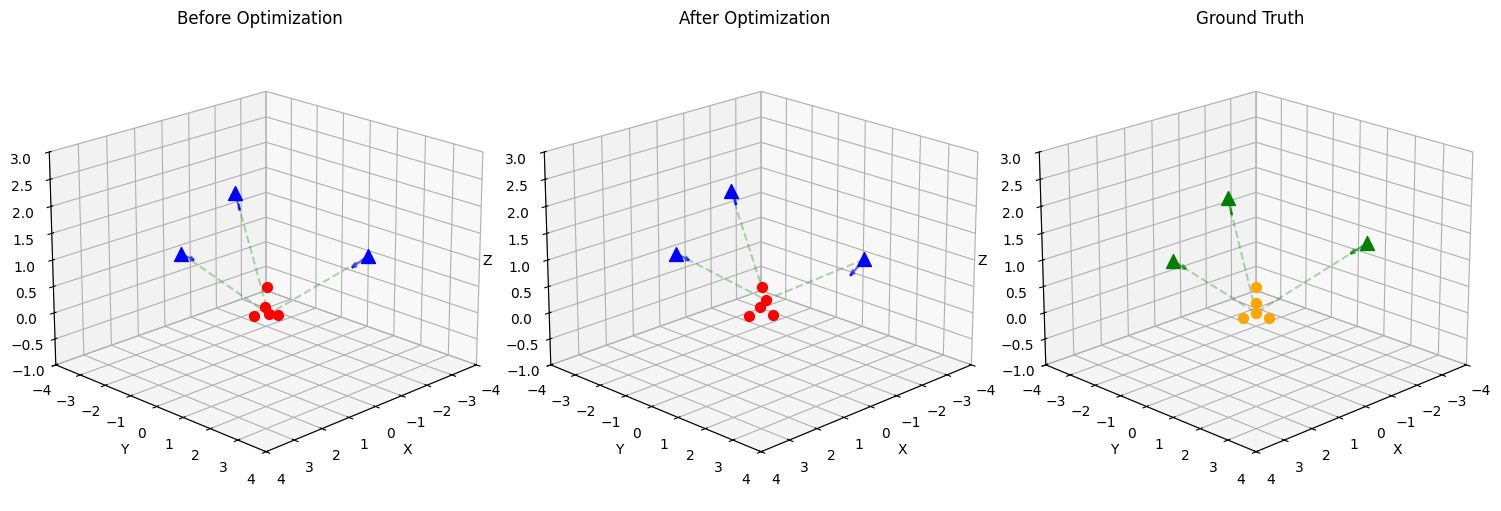


📊 최적화 정확도:
   카메라 0 위치 오차: 0.1661m
   카메라 1 위치 오차: 0.3583m
   카메라 2 위치 오차: 0.1508m

   평균 카메라 위치 오차: 0.2251m
   평균 랜드마크 위치 오차: 0.1326m


In [170]:
# 3D 시각화
fig = plt.figure(figsize=(15, 5))

# 최적화 전
ax1 = fig.add_subplot(131, projection='3d')
ax1.set_title('Before Optimization')

# 카메라 그리기
for i, pose in enumerate(problem['initial_poses']):
    pos = [float(p) for p in pose.t]
    ax1.scatter(pos[0], pos[1], pos[2], c='blue', s=100, marker='^')
    # 카메라 방향
    z_axis = pose.R.to_rotation_matrix()[:, 2]
    z_axis = [float(z) for z in z_axis]
    ax1.quiver(pos[0], pos[1], pos[2],
               -z_axis[0], -z_axis[1], -z_axis[2],  # 카메라는 -Z 방향을 봄
               length=0.5, color='blue', alpha=0.6)

# 랜드마크 그리기
for landmark in problem['initial_landmarks']:
    lm = [float(l) for l in landmark]
    ax1.scatter(lm[0], lm[1], lm[2], c='red', s=50)

# 관측선 그리기 (있는 경우)
for (cam_idx, lm_idx) in problem['measurements'].keys():
    cam_pos = [float(p) for p in problem['initial_poses'][cam_idx].t]
    lm_pos = [float(l) for l in problem['initial_landmarks'][lm_idx]]
    ax1.plot([cam_pos[0], lm_pos[0]], 
             [cam_pos[1], lm_pos[1]], 
             [cam_pos[2], lm_pos[2]], 'g--', alpha=0.3)

# 최적화 후
ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title('After Optimization')

# 최적화가 수행된 경우에만 최적화된 값 사용
if len(problem['measurements']) > 0 and 'result' in locals():
    # 최적화된 결과 가져오기
    if hasattr(result, 'optimized_values'):
        optimized_values = result.optimized_values
    elif hasattr(result, 'values'):
        optimized_values = result.values
    else:
        optimized_values = values  # 초기값 사용
else:
    optimized_values = values  # 측정값이 없으면 초기값 사용

# 최적화된 카메라
for i in range(len(problem['initial_poses'])):
    if f"T_{i}" in optimized_values:
        pose = optimized_values[f"T_{i}"]
        pos = [float(p) for p in pose.t]
        ax2.scatter(pos[0], pos[1], pos[2], c='blue', s=100, marker='^')
        z_axis = pose.R.to_rotation_matrix()[:, 2]
        z_axis = [float(z) for z in z_axis]
        ax2.quiver(pos[0], pos[1], pos[2],
                   -z_axis[0], -z_axis[1], -z_axis[2],  # 카메라는 -Z 방향을 봄
                   length=0.5, color='blue', alpha=0.6)

# 최적화된 랜드마크
for j in range(len(problem['initial_landmarks'])):
    if f"L_{j}" in optimized_values:
        landmark = optimized_values[f"L_{j}"]
        lm = [float(l) for l in landmark]
        ax2.scatter(lm[0], lm[1], lm[2], c='red', s=50)

# 관측선 그리기
for (cam_idx, lm_idx) in problem['measurements'].keys():
    if f"T_{cam_idx}" in optimized_values and f"L_{lm_idx}" in optimized_values:
        cam_pos = [float(p) for p in optimized_values[f"T_{cam_idx}"].t]
        lm_pos = [float(l) for l in optimized_values[f"L_{lm_idx}"]]
        ax2.plot([cam_pos[0], lm_pos[0]], 
                 [cam_pos[1], lm_pos[1]], 
                 [cam_pos[2], lm_pos[2]], 'g--', alpha=0.3)

# Ground truth
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title('Ground Truth')

for pose in problem['true_poses']:
    pos = [float(p) for p in pose.t]
    ax3.scatter(pos[0], pos[1], pos[2], c='green', s=100, marker='^')
    z_axis = pose.R.to_rotation_matrix()[:, 2]
    z_axis = [float(z) for z in z_axis]
    ax3.quiver(pos[0], pos[1], pos[2],
               -z_axis[0], -z_axis[1], -z_axis[2],  # 카메라는 -Z 방향을 봄
               length=0.5, color='green', alpha=0.6)

for landmark in problem['true_landmarks']:
    lm = [float(l) for l in landmark]
    ax3.scatter(lm[0], lm[1], lm[2], c='orange', s=50)

# 관측선 그리기
for (cam_idx, lm_idx) in problem['measurements'].keys():
    cam_pos = [float(p) for p in problem['true_poses'][cam_idx].t]
    lm_pos = [float(l) for l in problem['true_landmarks'][lm_idx]]
    ax3.plot([cam_pos[0], lm_pos[0]], 
             [cam_pos[1], lm_pos[1]], 
             [cam_pos[2], lm_pos[2]], 'g--', alpha=0.3)

# 축 설정
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-1, 3])
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# 에러 분석
print("\n📊 최적화 정확도:")

# 측정값이 있는 경우에만 에러 계산
if len(problem['measurements']) > 0 and 'result' in locals():
    pose_errors = []
    for i in range(len(problem['true_poses'])):
        true_pose = problem['true_poses'][i]
        if f"T_{i}" in optimized_values:
            opt_pose = optimized_values[f"T_{i}"]
            
            # Convert to numpy arrays for error calculation
            true_pos = np.array([float(p) for p in true_pose.t])
            opt_pos = np.array([float(p) for p in opt_pose.t])
            
            pos_error = np.linalg.norm(true_pos - opt_pos)
            pose_errors.append(pos_error)
            print(f"   카메라 {i} 위치 오차: {pos_error:.4f}m")

    landmark_errors = []
    for j in range(len(problem['true_landmarks'])):
        true_lm = problem['true_landmarks'][j]
        if f"L_{j}" in optimized_values:
            opt_lm = optimized_values[f"L_{j}"]
            
            # Convert to numpy arrays
            true_lm_np = np.array([float(l) for l in true_lm])
            opt_lm_np = np.array([float(l) for l in opt_lm])
            
            lm_error = np.linalg.norm(true_lm_np - opt_lm_np)
            landmark_errors.append(lm_error)

    if pose_errors:
        print(f"\n   평균 카메라 위치 오차: {np.mean(pose_errors):.4f}m")
    if landmark_errors:
        print(f"   평균 랜드마크 위치 오차: {np.mean(landmark_errors):.4f}m")
else:
    print("   측정값이 없어 최적화가 수행되지 않았습니다.")
    print("   카메라가 랜드마크를 제대로 관측하도록 배치를 조정하세요.")

## 6. ATAN 카메라 모델

광각 렌즈를 위한 비선형 카메라 모델도 지원합니다.

🐟 ATAN (Fisheye) 카메라 모델:
   왜곡 파라미터 ω: 0.5


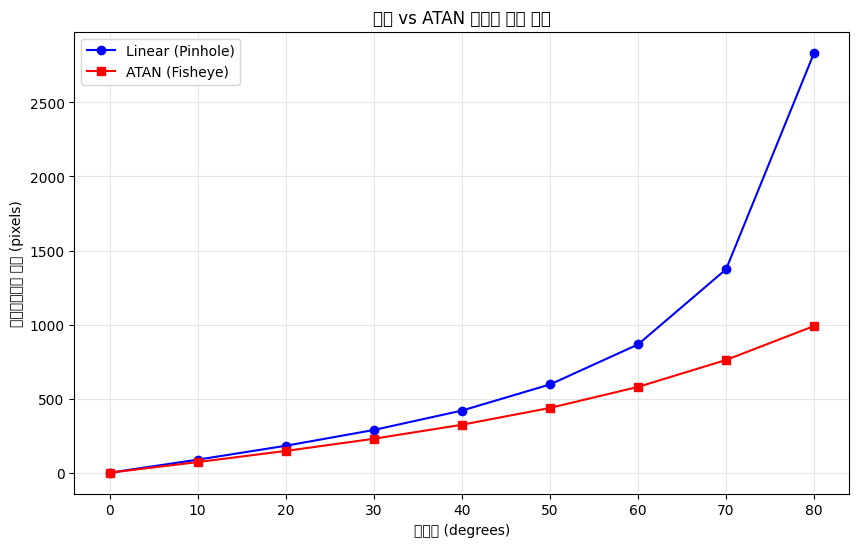


💡 ATAN 모델의 특징:
   - 광각에서도 안정적인 투영
   - 이미지 가장자리에서 압축 효과
   - 180도 이상의 FOV 지원 가능


In [171]:
# ATAN 카메라 모델 (fisheye 렌즈)
atan_cal = sf.ATANCameraCal(
    focal_length=[400.0, 400.0],
    principal_point=[320.0, 240.0],
    omega=0.5  # 왜곡 파라미터
)

print("🐟 ATAN (Fisheye) 카메라 모델:")
print(f"   왜곡 파라미터 ω: {float(atan_cal.omega)}")

# 선형 vs ATAN 비교
test_angles = np.linspace(0, 80, 9)  # 0도에서 80도까지

linear_pixels = []
atan_pixels = []

for angle_deg in test_angles:
    angle_rad = np.deg2rad(angle_deg)
    
    # 카메라 중심에서 angle만큼 벗어난 점
    point_3d = sf.V3(
        np.sin(angle_rad),
        0.0,
        np.cos(angle_rad)
    )
    
    # 선형 투영
    pixel_linear, _ = linear_cal.pixel_from_camera_point(point_3d)
    linear_pixels.append(float(pixel_linear[0]) - 320.0)  # 중심에서의 거리
    
    # ATAN 투영
    pixel_atan, _ = atan_cal.pixel_from_camera_point(point_3d)
    atan_pixels.append(float(pixel_atan[0]) - 320.0)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(test_angles, linear_pixels, 'b-o', label='Linear (Pinhole)')
plt.plot(test_angles, atan_pixels, 'r-s', label='ATAN (Fisheye)')
plt.xlabel('입사각 (degrees)')
plt.ylabel('이미지에서의 거리 (pixels)')
plt.title('선형 vs ATAN 카메라 모델 비교')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n💡 ATAN 모델의 특징:")
print("   - 광각에서도 안정적인 투영")
print("   - 이미지 가장자리에서 압축 효과")
print("   - 180도 이상의 FOV 지원 가능")

## 7. 요약 및 핵심 포인트

### 🎓 이 챕터에서 배운 내용:

1. **SymForce 카메라 모델**
   - LinearCameraCal: 표준 핀홀 모델
   - ATANCameraCal: 광각/fisheye 렌즈
   - 투영과 역투영 연산

2. **Epsilon 처리**
   - z=0 특이점 안전 처리
   - 수치적으로 안정적인 투영

3. **PosedCamera**
   - 월드-카메라 좌표 변환
   - 글로벌 좌표계에서의 투영

4. **번들 조정**
   - 카메라 포즈와 3D 점 동시 최적화
   - Visual feature 에러 함수
   - SymForce를 사용한 효율적 구현

### 💡 실전 팁:

1. **카메라 모델 선택**
   - 일반 렌즈: LinearCameraCal
   - 광각 렌즈: ATANCameraCal
   - 필요시 커스텀 모델 구현

2. **특이점 처리**
   - 항상 epsilon 사용
   - 카메라 뒤 점 필터링
   - 이미지 경계 체크

3. **최적화 안정성**
   - 좋은 초기값 중요
   - Robust kernel 사용 고려
   - 충분한 관측값 확보

## 🏋️ 연습 문제

### 문제 1: 스테레오 카메라
두 카메라 간의 삼각측량을 구현하고 깊이 추정 정확도를 분석해보세요.

### 문제 2: Rolling Shutter 효과
움직이는 카메라의 rolling shutter 효과를 모델링하고 보정해보세요.

### 문제 3: 다중 카메라 시스템
4개 카메라로 구성된 전방향 카메라 시스템을 설계하고 최적화해보세요.

In [172]:
# 연습 문제를 위한 시작 코드

# 문제 1: 스테레오 삼각측량
def triangulate_stereo_point(
    left_pixel: sf.V2,
    right_pixel: sf.V2,
    left_camera: sf.PosedCamera,
    right_camera: sf.PosedCamera,
    epsilon: sf.Scalar
) -> sf.V3:
    """두 카메라 관측으로부터 3D 점 복원"""
    # 여기에 구현
    pass

In [173]:
# Let's test the fixed create_bundle_adjustment_problem function
import numpy as np

# Test camera orientation calculation
for i in range(3):
    angle = 2 * np.pi * i / 3
    x = 3 * np.cos(angle)
    y = 3 * np.sin(angle)
    z = 1.5
    
    cam_pos = np.array([x, y, z])
    target = np.array([0, 0, 0])
    
    # Z axis should point from target to camera (camera looks in -Z direction)
    z_axis = cam_pos - target
    z_axis = z_axis / np.linalg.norm(z_axis)
    
    # The camera forward direction (-Z) should point toward origin
    cam_forward = -z_axis
    
    print(f"Camera {i}:")
    print(f"  Position: {cam_pos}")
    print(f"  Z-axis: {z_axis}")
    print(f"  Forward (-Z): {cam_forward}")
    print(f"  Should point to origin: {target - cam_pos} (normalized: {(target - cam_pos) / np.linalg.norm(target - cam_pos)})")
    print()

Camera 0:
  Position: [3.  0.  1.5]
  Z-axis: [0.89442719 0.         0.4472136 ]
  Forward (-Z): [-0.89442719 -0.         -0.4472136 ]
  Should point to origin: [-3.   0.  -1.5] (normalized: [-0.89442719  0.         -0.4472136 ])

Camera 1:
  Position: [-1.5         2.59807621  1.5       ]
  Z-axis: [-0.4472136   0.77459667  0.4472136 ]
  Forward (-Z): [ 0.4472136  -0.77459667 -0.4472136 ]
  Should point to origin: [ 1.5        -2.59807621 -1.5       ] (normalized: [ 0.4472136  -0.77459667 -0.4472136 ])

Camera 2:
  Position: [-1.5        -2.59807621  1.5       ]
  Z-axis: [-0.4472136  -0.77459667  0.4472136 ]
  Forward (-Z): [ 0.4472136   0.77459667 -0.4472136 ]
  Should point to origin: [ 1.5         2.59807621 -1.5       ] (normalized: [ 0.4472136   0.77459667 -0.4472136 ])



In [174]:
# Test the camera coordinate transformation
print("🧪 Testing camera coordinate transformation...")

# Create a simple test
test_calibration = sf.LinearCameraCal(
    focal_length=[500.0, 500.0],
    principal_point=[320.0, 240.0]
)

# Camera at (3, 0, 1.5) looking at origin
cam_pos = np.array([3.0, 0.0, 1.5])
target = np.array([0.0, 0.0, 0.0])

# Create a simple pose where camera looks along -X axis (toward origin)
# In camera frame: Z points away from target (positive X world), X points down, Y points left
R_matrix = np.array([
    [0, 0, 1],    # Camera X = World Z
    [0, 1, 0],    # Camera Y = World Y  
    [-1, 0, 0]    # Camera Z = -World X (camera looks in -Z direction)
])

# Create pose - camera at (3, 0, 1.5) looking toward origin
test_pose = sf.Pose3(
    R=sf.Rot3.from_rotation_matrix(R_matrix),
    t=sf.V3(3.0, 0.0, 1.5)
)

# Test landmark at origin
test_landmark = sf.V3(0.0, 0.0, 0.0)

# Transform to camera coordinates using inverse
landmark_cam = test_pose.inverse() * test_landmark

print(f"Camera position: {[float(p) for p in test_pose.t]}")
print(f"Target position: {[float(p) for p in test_landmark]}")
print(f"Camera coordinate of origin: {[float(c) for c in landmark_cam]}")
print(f"Z coordinate: {float(landmark_cam[2]):.3f}")

# Expected: Since camera is at (3, 0, 1.5) and looks toward origin,
# the origin should be at approximately (0, 0, 3.35) in camera coordinates
# (distance from camera to origin)

# Let's also test with PosedCamera to verify
posed_camera = sf.PosedCamera(
    pose=test_pose,
    calibration=test_calibration,
    image_size=(640, 480)
)

pixel, is_valid = posed_camera.pixel_from_global_point(test_landmark)
print(f"\nUsing PosedCamera:")
print(f"Pixel: {[float(p) for p in pixel]}")
print(f"Valid: {is_valid}")
print(f"Expected: near center [320, 240] if transformation is correct")

🧪 Testing camera coordinate transformation...
Camera position: [3.0, 0.0, 1.5]
Target position: [0.0, 0.0, 0.0]
Camera coordinate of origin: [1.5, 0.0, -3.0]
Z coordinate: -3.000

Using PosedCamera:
Pixel: [3.377699720527876e+17, 240.0]
Valid: 0
Expected: near center [320, 240] if transformation is correct
